In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub
fall_ml_2_mipt_2024_path = kagglehub.competition_download('fall-ml-2-mipt-2024')

In [2]:
from sklearn.preprocessing import StandardScaler  
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.pipeline import make_pipeline 

train = pd.read_csv(fall_ml_2_mipt_2024_path+"/train.csv")
target = pd.read_csv(fall_ml_2_mipt_2024_path+"/test.csv")
rng = np.random.RandomState(42)

X = train.drop(columns=['y', 'index'])
y = train['y']                         
X_target = target.drop(columns=['index']) 

# X = X.drop(columns='x18')
# X_target = X_target.drop(columns='x18')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

In [3]:
import statistics

dataset = pd.concat([X_train, y_train], axis=1)
stats = []
cols = dataset.columns.tolist()
for c in cols:
    s = {'name' : c}
    d = dataset[c]
    s['min'] = np.min(d)
    s['max'] = np.max(d)
    s['mean'] = statistics.mean(d)
    s['stdev'] = statistics.stdev(d)
    uniques, counts = np.unique(d, return_counts=True)
    s['uniques'] = uniques if len(uniques) < 20 else "Many"
    s['uniques_cnt'] = counts if len(uniques) < 20 else "Many"
    s['uniques_len'] = len(uniques)
    s['uniques_type'] = uniques.dtype
    stats.append(s)

stats = pd.DataFrame(stats)
display(stats)

,name,min,max,mean,stdev,uniques,uniques_cnt,uniques_len,uniques_type
0,x1,10.00,23.00,15.156641,4.187318,"[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17....","[1762, 2558, 430, 623, 806, 868, 651, 916, 105...",14,float64
1,x2,0.00,1.00,0.747891,0.434241,"[0, 1]","[3227, 9573]",2,int64
2,x3,19.00,60.00,33.041172,8.952660,Many,Many,42,int64
3,x4,0.00,1.00,0.197187,0.397891,"[0, 1]","[10276, 2524]",2,int64
4,x5,1.00,17.00,1.179688,0.569336,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17]","[11087, 1352, 247, 70, 20, 9, 5, 5, 1, 1, 1, 1...",13,int64
5,x6,0.00,17023.76,193.238022,413.175484,Many,Many,6606,float64
6,x7,0.00,0.00,0.000000,0.000000,[0.0],[12800],1,float64
7,x8,0.00,1455.44,52.264981,80.004701,Many,Many,7289,float64
8,x9,0.00,2502.37,276.728302,253.088851,Many,Many,11445,float64
9,x10,0.00,11.40,0.070247,0.418333,Many,Many,251,float64


In [4]:
def concat(X, y):
    return pd.concat([X_train, y_train], axis=1)

def featureSelection(X):
    for index, row in stats.iterrows():
        if row['uniques_len'] == 1:
            print(f"Dropping {row['name']}")
            X.drop(columns=row['name'], inplace=True)

    for f in ['x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x15', 'x16', 'x17', 'x18']:
        print(f"Adjusting {f} with log(x+1)")
        X[f] = np.log(X[f] + 2)

    # X['x18^2'] = X['x18']**2

    print(f"Dropping x9, correllated to x18")
    X.drop(columns='x9', inplace=True)

    return X

def printCorrelation(X):
    corr = X.corr()
    plt.matshow(corr)
    plt.colorbar()
    plt.show()
    display(corr)

def drawUnivariate(X):
    for f in X.columns:
        if f != 'y':
            fig, ax = plt.subplots(1,2, figsize=(12, 4))
            sns.histplot(X, ax=ax[0], x=f, bins=40)
            sns.histplot(X, ax=ax[1], x=f, y='y', bins=40)
            plt.show()

Dropping x7
Dropping x13
Dropping x14
Adjusting x6 with log(x+1)
Adjusting x8 with log(x+1)
Adjusting x9 with log(x+1)
Adjusting x10 with log(x+1)
Adjusting x11 with log(x+1)
Adjusting x12 with log(x+1)
Adjusting x15 with log(x+1)
Adjusting x16 with log(x+1)
Adjusting x17 with log(x+1)
Adjusting x18 with log(x+1)
Dropping x9, correllated to x18
Dropping x7
Dropping x13
Dropping x14
Adjusting x6 with log(x+1)
Adjusting x8 with log(x+1)
Adjusting x9 with log(x+1)
Adjusting x10 with log(x+1)
Adjusting x11 with log(x+1)
Adjusting x12 with log(x+1)
Adjusting x15 with log(x+1)
Adjusting x16 with log(x+1)
Adjusting x17 with log(x+1)
Adjusting x18 with log(x+1)
Dropping x9, correllated to x18
Dropping x7
Dropping x13
Dropping x14
Adjusting x6 with log(x+1)
Adjusting x8 with log(x+1)
Adjusting x9 with log(x+1)
Adjusting x10 with log(x+1)
Adjusting x11 with log(x+1)
Adjusting x12 with log(x+1)
Adjusting x15 with log(x+1)
Adjusting x16 with log(x+1)
Adjusting x17 with log(x+1)
Adjusting x18 with 

,x1,x2,x3,x4,x5,x6,x8,x10,x11,x12,x15,x16,x17,x18
676,23.0,1,39,0,1,6.466347,4.539351,0.693147,1.178655,6.235136,0.693147,0.693147,0.693147,6.554332
12113,18.0,1,23,0,2,4.220537,2.796061,0.693147,1.358409,0.875469,0.693147,0.693147,0.693147,5.036173
7077,11.0,1,29,0,1,6.922141,5.873863,0.779325,0.891998,6.413098,0.693147,1.617406,0.693147,6.520724
13005,16.0,0,41,0,1,0.693147,2.038620,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,5.620038
12123,14.0,0,36,0,1,5.593186,1.121678,0.693147,0.693147,5.808743,0.693147,0.693147,0.693147,5.970496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,18.0,1,33,0,1,0.693147,1.504077,0.693147,0.693147,4.353370,0.693147,0.693147,0.693147,5.505738
5390,18.0,1,38,0,1,0.693147,3.144583,0.693147,1.187843,2.623218,0.693147,0.693147,0.693147,5.887963
860,15.0,0,31,0,1,0.693147,3.060583,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,5.691642
15795,17.0,0,51,0,1,5.003745,2.855320,0.693147,1.266948,4.861903,0.693147,0.693147,0.693147,4.975837


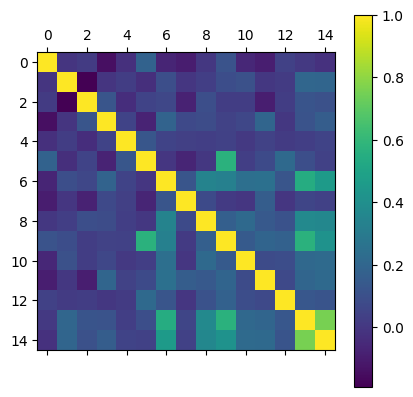

,x1,x2,x3,x4,x5,x6,x8,x10,x11,x12,x15,x16,x17,x18,y
x1,1.000000,-0.009519,0.015520,-0.143374,-0.026359,0.181695,-0.068797,-0.096702,0.001297,0.110937,-0.058870,-0.092265,0.039040,0.007329,-0.022265
x2,-0.009519,1.000000,-0.192416,-0.010706,0.025235,-0.030325,0.095493,-0.002597,0.031108,0.087160,0.103842,0.001109,0.013905,0.199533,0.196568
x3,0.015520,-0.192416,1.000000,0.123816,-0.034776,0.048101,0.060740,-0.079304,0.095301,0.022415,0.024463,-0.090581,0.023685,0.115156,0.103773
x4,-0.143374,-0.010706,0.123816,1.000000,0.046033,-0.072487,0.186181,0.070963,0.083626,0.041971,0.062836,0.197946,0.001452,0.111768,0.157643
x5,-0.026359,0.025235,-0.034776,0.046033,1.000000,0.127507,0.049429,0.031817,0.029326,0.037234,0.005623,0.042908,0.016945,0.030968,0.045447
x6,0.181695,-0.030325,0.048101,-0.072487,0.127507,1.000000,-0.004911,-0.067705,-0.000937,0.571165,0.028695,0.077420,0.217034,0.094233,0.040392
x8,-0.068797,0.095493,0.060740,0.186181,0.049429,-0.004911,1.000000,0.120312,0.339217,0.324782,0.241227,0.248278,0.122064,0.546873,0.455778
x10,-0.096702,-0.002597,-0.079304,0.070963,0.031817,-0.067705,0.120312,1.000000,0.076787,0.011440,-0.003149,0.161413,-0.001659,0.054534,0.038115
x11,0.001297,0.031108,0.095301,0.083626,0.029326,-0.000937,0.339217,0.076787,1.000000,0.167888,0.215822,0.142025,0.109062,0.367483,0.357937
x12,0.110937,0.087160,0.022415,0.041971,0.037234,0.571165,0.324782,0.011440,0.167888,1.000000,0.145581,0.193813,0.178155,0.571012,0.416396


In [5]:
X_train = featureSelection(X_train)
X_target = featureSelection(X_target)
X_test = featureSelection(X_test)
display(X_train)

printCorrelation(concat(X_train, y_train))

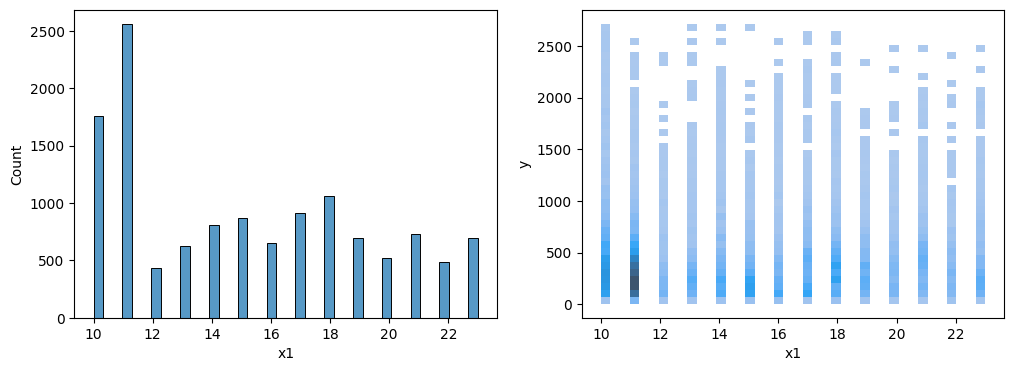

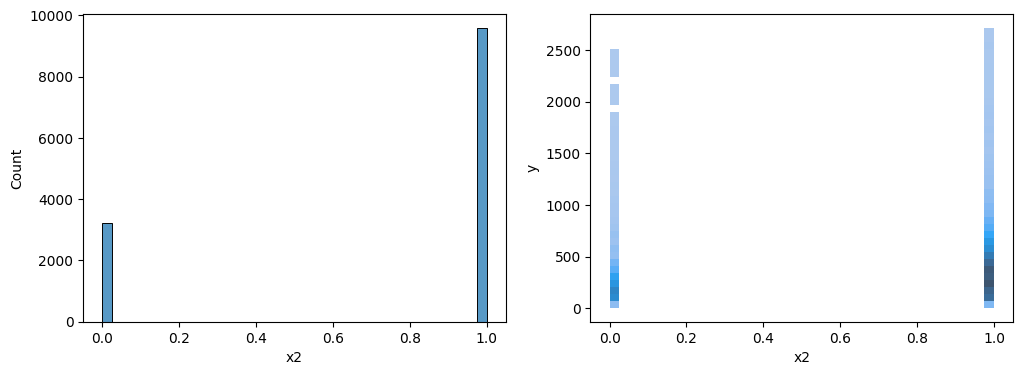

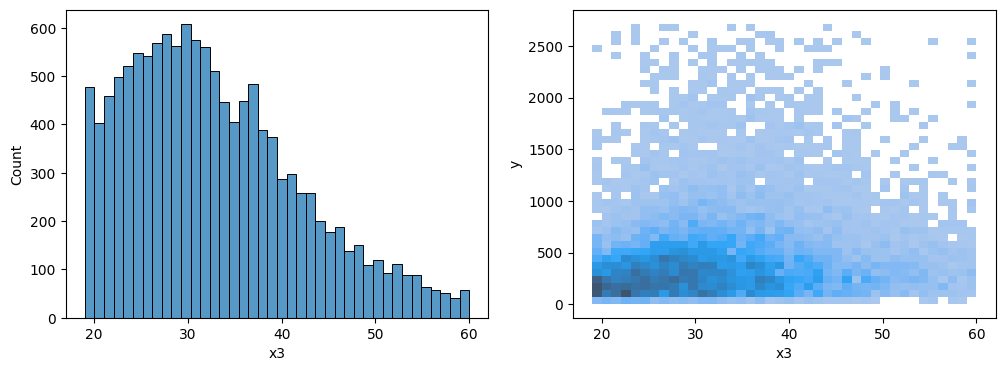

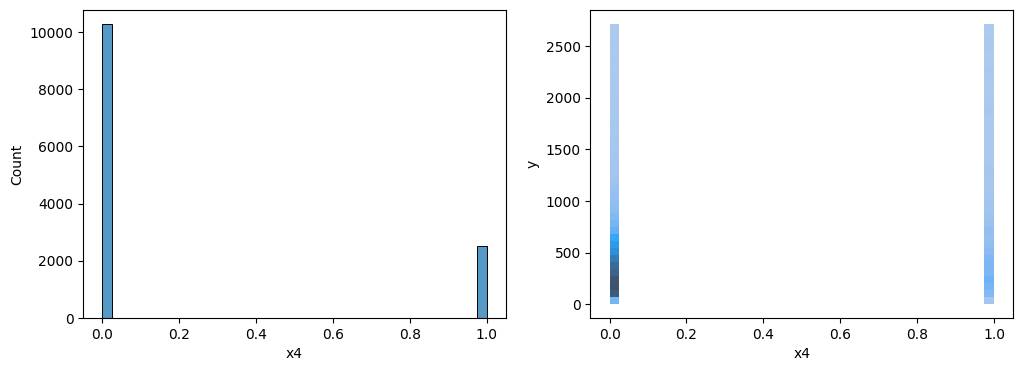

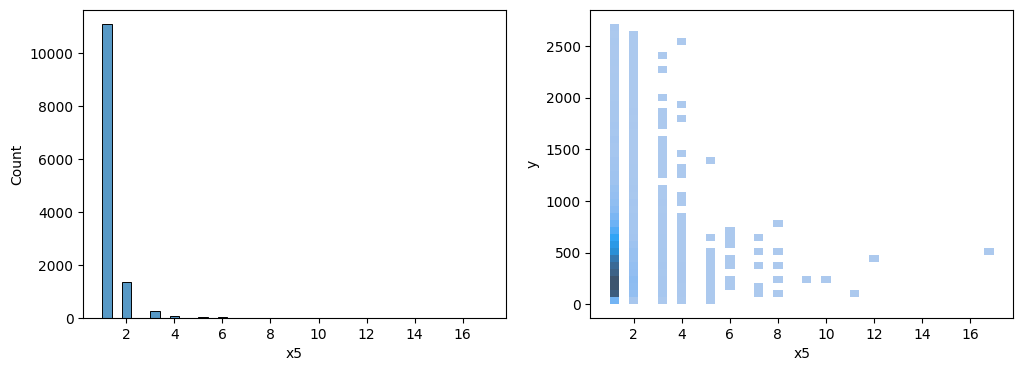

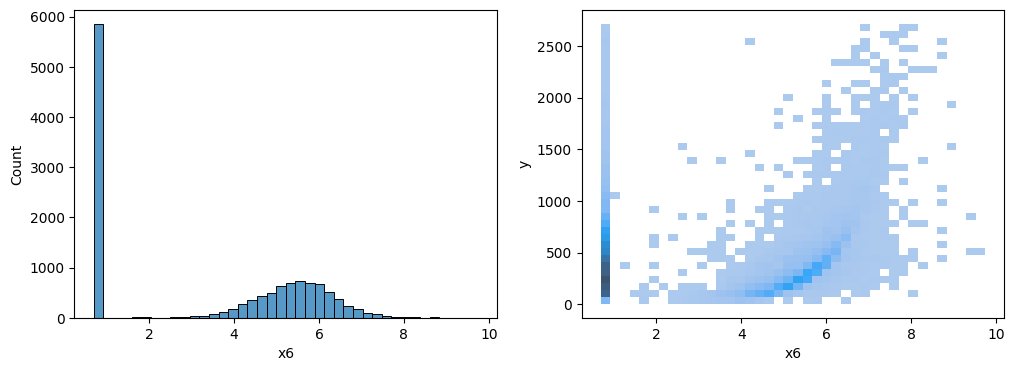

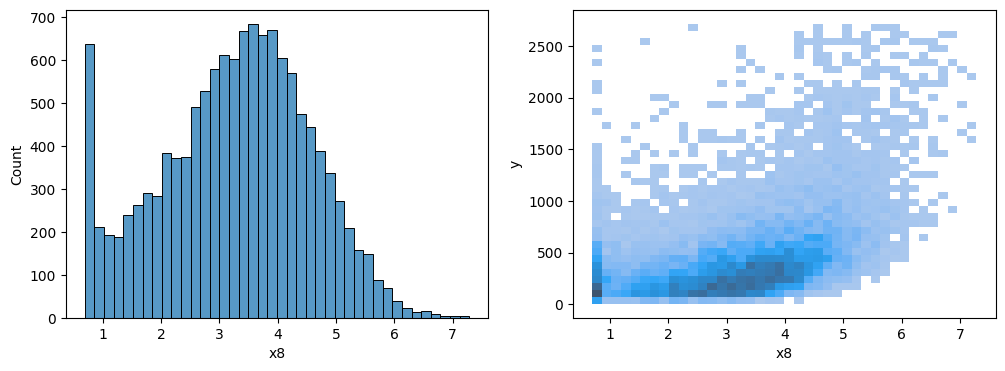

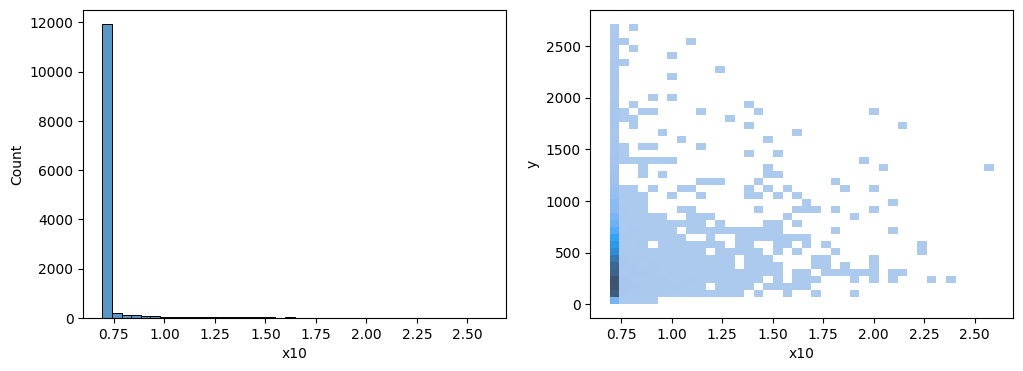

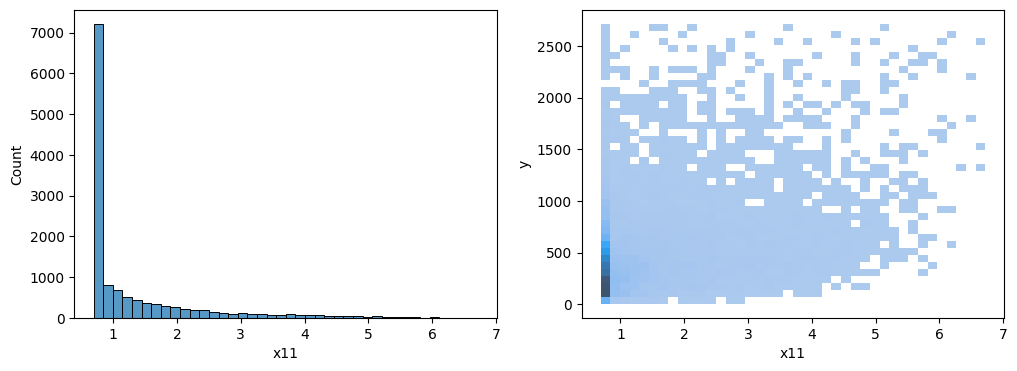

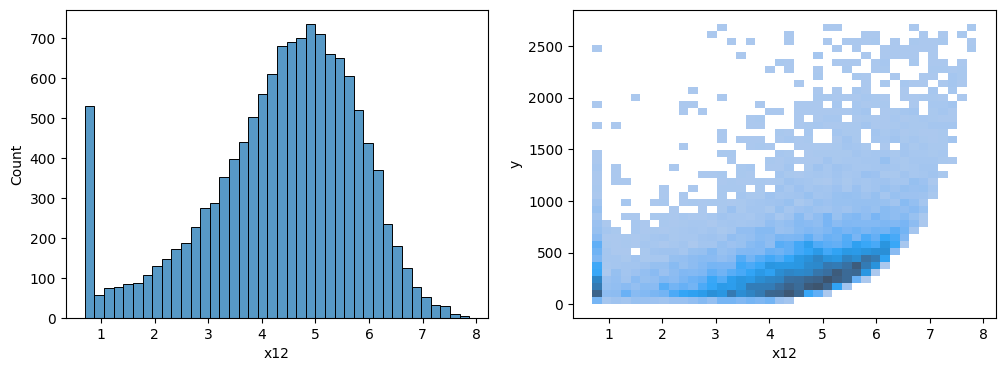

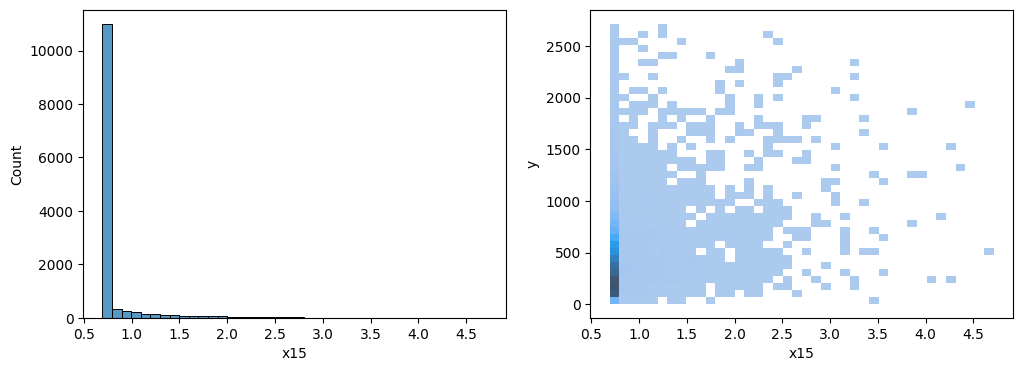

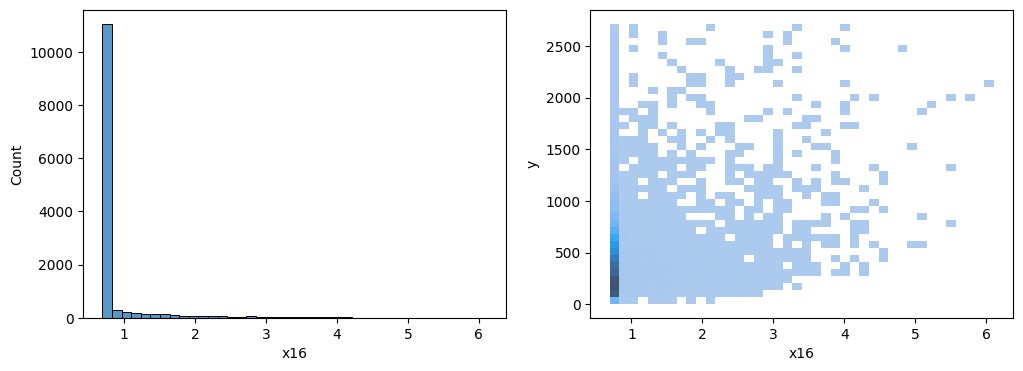

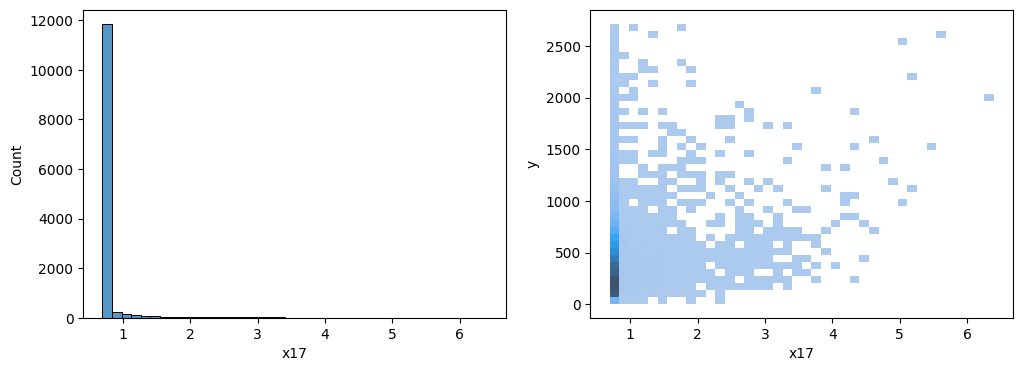

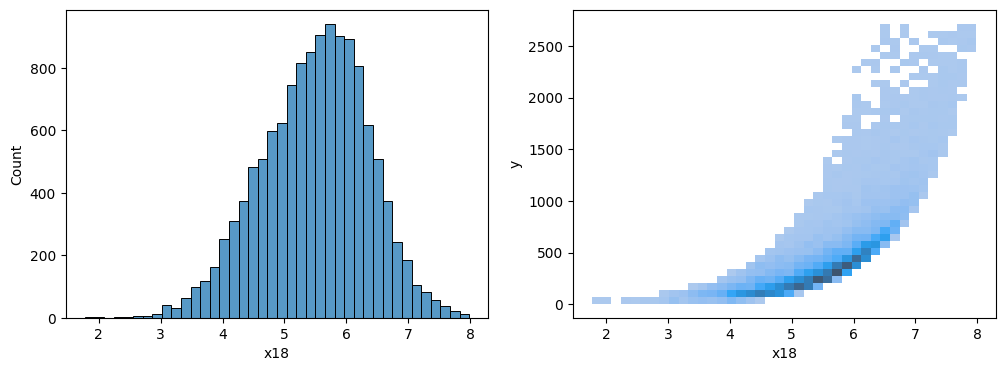

In [6]:
drawUnivariate(concat(X_train, y_train))

In [7]:
e = 1e-3

def mape_loss(y_pred, data):
    y_true = data.get_label()
    grad = (y_pred - y_true) / np.maximum(e, np.abs(y_true))
    hess = 1 / np.maximum(e, np.abs(y_true))
    return grad, hess

def mape_metric(y_pred, data):
    y_true = data.get_label()
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(e, np.abs(y_true))))
    return 'mape', mape, False


In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": mape_loss,
    "metric": "None",
    "learning_rate": 0.005,
    "num_leaves": 31,
    "random_state": 123,
    "max_bin": 1024,
#    "lambda_l1": 0.1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    feval=mape_metric,
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)], 
)
display(model)

y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)
mape_test  = mean_absolute_percentage_error(y_test, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
print(f"MAPE: train={mape_train}, test={mape_test}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	training's mape: 0.238101	valid_1's mape: 0.242947


MAPE: train=0.238100577377691, test=0.24294686300486934


In [9]:
import shap
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.force(shap_values[:500])

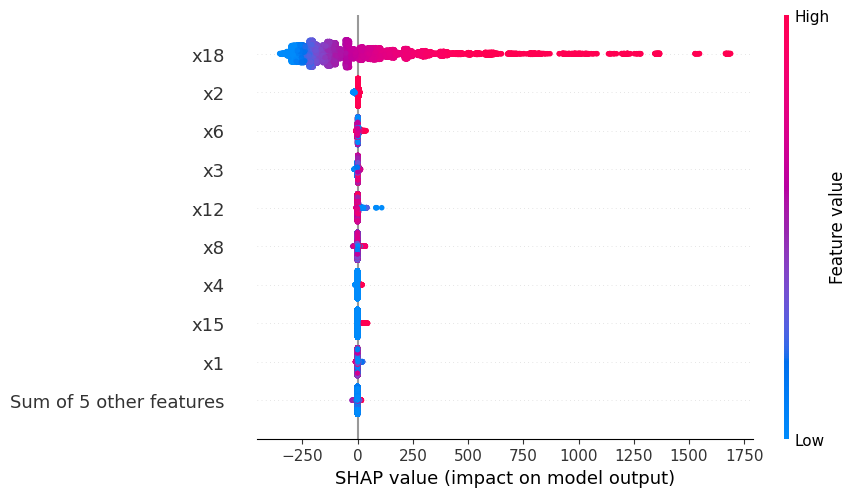

In [10]:
shap.plots.beeswarm(shap_values)

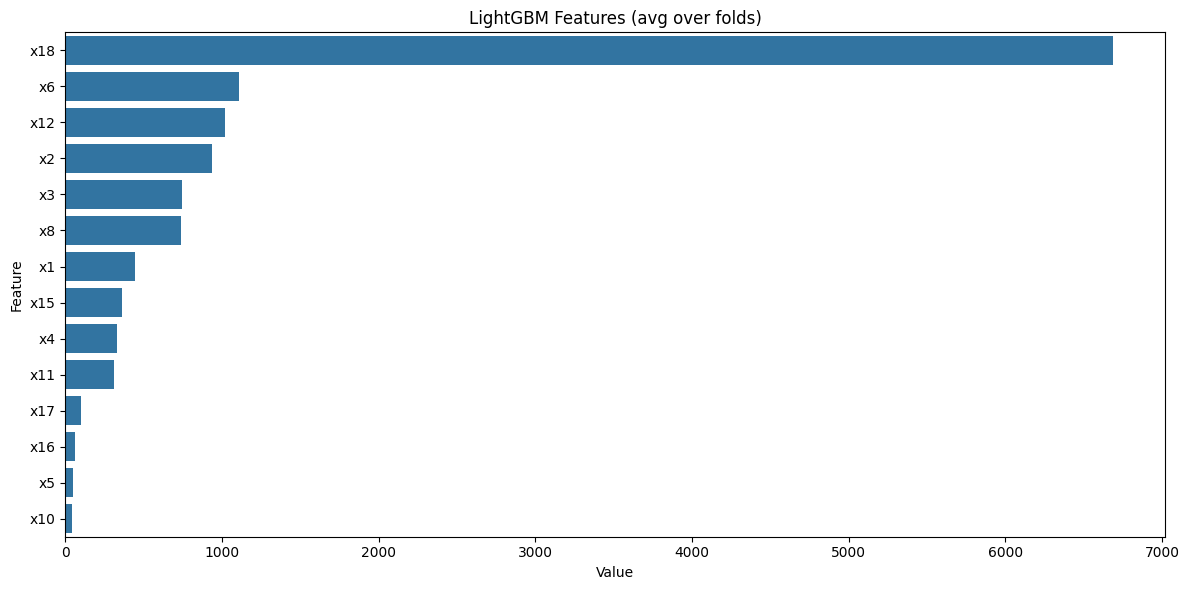

In [11]:
def plotImp(model, X , num = 20, fig_size = (12, 6)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

plotImp(model, X_train)

In [12]:
y_target_pred = model.predict(X_target)

submission = pd.DataFrame(
    {"index": target["index"], "y": y_target_pred}
)
submission.to_csv("test.csv", index=False)

In [13]:
from flaml import AutoML
from flaml.automl.model import LGBMEstimator

eps = 1e-3
def mape_loss(y_true, y_pred):
    grad = (y_pred - y_true) / np.maximum(eps, np.abs(y_true))
    hess = 1 / np.maximum(eps, np.abs(y_true))
    return grad, hess

class MyLGBM(LGBMEstimator):
    """LGBMEstimator with mape_loss as the objective function"""

    def __init__(self, **config):
        super().__init__(objective=mape_loss, **config)

model = AutoML()
model.add_learner(learner_name="my_lgbm", learner_class=MyLGBM)
model.fit(
    X_train,
    y_train,
    task="regression",
    metric="mape",
    estimator_list=["my_lgbm"],
    time_budget=60,
)

[flaml.automl.logger: 12-15 17:21:22] {1728} INFO - task = regression
[flaml.automl.logger: 12-15 17:21:22] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-15 17:21:22] {1838} INFO - Minimizing error metric: mape
[flaml.automl.logger: 12-15 17:21:22] {1955} INFO - List of ML learners in AutoML Run: ['my_lgbm']
[flaml.automl.logger: 12-15 17:21:22] {2258} INFO - iteration 0, current learner my_lgbm
[flaml.automl.logger: 12-15 17:21:22] {2393} INFO - Estimated sufficient time budget=331s. Estimated necessary time budget=0s.
[flaml.automl.logger: 12-15 17:21:22] {2442} INFO -  at 0.1s,	estimator my_lgbm's best error=0.6780,	best estimator my_lgbm's best error=0.6780
[flaml.automl.logger: 12-15 17:21:22] {2258} INFO - iteration 1, current learner my_lgbm
[flaml.automl.logger: 12-15 17:21:22] {2442} INFO -  at 0.1s,	estimator my_lgbm's best error=0.6780,	best estimator my_lgbm's best error=0.6780
[flaml.automl.logger: 12-15 17:21:22] {2258} INFO - iteration 2, current lear

In [15]:
import shap
shap.initjs()

explainer = shap.Explainer(model.model.estimator)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.force(shap_values[:500])

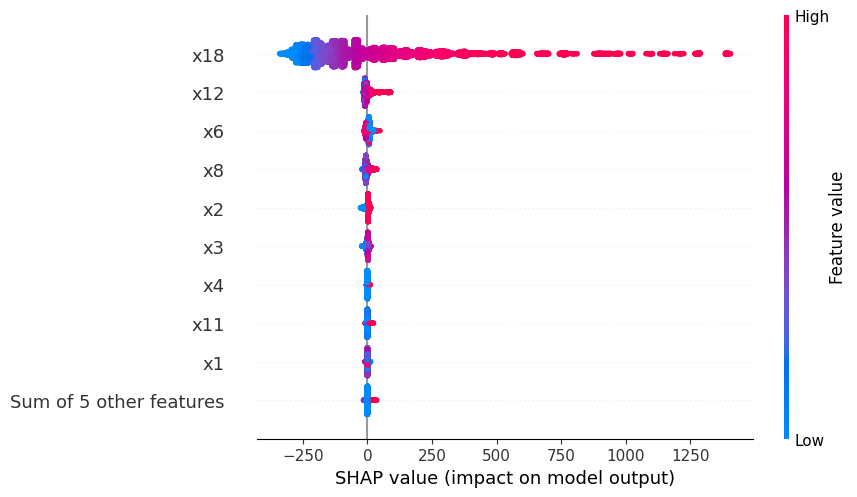

In [16]:
shap.plots.beeswarm(shap_values)

In [17]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)
mape_test  = mean_absolute_percentage_error(y_test, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
print(f"MAPE: train={mape_train}, test={mape_test}")


MAPE: train=0.2357902525822, test=0.2451406578528342
